OG PyTorch code by: Sriram Ravindran, sriram@ucsd.edu

Original paper - https://arxiv.org/abs/1611.08024

Please reach out to me if you spot an error.

# EEGNet core

In [37]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

# MNE stuff
import mne

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

#### Here's the description from the paper


<img src="EEGNet.png" style="width: 700px; float:left;">

#### the basic model + does it work?

we create an EEGNet class, with 2 arguments - channels, and samples. 
- first convolution kernel will have a width corresponding to the number of EEG channels/samples
- based on 'reshape value'- adjust fc1

In [38]:
class EEGNet(nn.Module):
    def __init__(self, channels, samples, verbose = False):
        super(EEGNet, self).__init__()

        self.kernellength = channels
        self.T = samples # AKA samples

        self.filter_sizing = 16

        self.verbose = verbose
        
        # Layer 1
        # input shape [n (?), kernel height, samples, kernel width]
        # corresponds [n (?), kern. h (=1)., time pts, kern w = channels]
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = self.filter_sizing, kernel_size = (1, self.kernellength), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(self.filter_sizing, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((self.filter_sizing, 17, 0, 1))
        self.conv2 = nn.Conv2d(in_channels = 1, out_channels = 4, kernel_size = (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)

        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(in_channels = 4, out_channels = 4, kernel_size = (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        self.fc1 = nn.Linear(152, 1)
        # NOTE: if error, sadly must recursively change the first value here to the "reshape value" in output

    def forward(self, x):
        # Layer 1
        if self.verbose:
            print("Layer 1 input:", x.shape)

        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)

        if self.verbose:
            print("Layer 1 output:", x.shape)

        # Layer 2
        if self.verbose:
            print("Layer 2 input:", x.shape)

        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        if self.verbose:
            print("Layer 2 output:", x.shape)

        # Layer 3
        if self.verbose:
            print("Layer 3 input:", x.shape)
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        if self.verbose:
            print("Layer 3 output:", x.shape, "layer 3 size: ", x.size)
            print(f"Size of x after pooling3: {x.shape}")
            print(f"reshape value: {x.shape[1]*x.shape[2]*x.shape[3]}")

        # FC Layer
        x = x.reshape(-1, x.shape[1]*x.shape[2]*x.shape[3])
        if self.verbose:
            print("FC Layer input:", x.shape)
            print(f"testing {self.fc1}")

        x = F.sigmoid(self.fc1(x))

        if self.verbose:
            print("FC Layer output:", x.shape)
        return x



In [39]:
# instantiate model + brief test, retro-fit reshape value if you change channels + samples
testkern = 2
testT = 300
testmodel = EEGNet(channels=testkern, samples=testT, verbose = True)
print (testmodel.forward(Variable(torch.Tensor(np.random.rand(32, 1, testT, testkern))))) # again, n, kern height, samples, kern width/EEG channels/electrodes

Layer 1 input: torch.Size([32, 1, 300, 2])
Layer 1 output: torch.Size([32, 1, 16, 300])
Layer 2 input: torch.Size([32, 1, 16, 300])
Layer 2 output: torch.Size([32, 4, 4, 76])
Layer 3 input: torch.Size([32, 4, 4, 76])
Layer 3 output: torch.Size([32, 4, 2, 19]) layer 3 size:  <built-in method size of Tensor object at 0x2a3f5eb60>
Size of x after pooling3: torch.Size([32, 4, 2, 19])
reshape value: 152
FC Layer input: torch.Size([32, 152])
testing Linear(in_features=152, out_features=1, bias=True)
FC Layer output: torch.Size([32, 1])
tensor([[0.6098],
        [0.6130],
        [0.6859],
        [0.7682],
        [0.4476],
        [0.4454],
        [0.5349],
        [0.5819],
        [0.6338],
        [0.6059],
        [0.6165],
        [0.6897],
        [0.8642],
        [0.7229],
        [0.6644],
        [0.7241],
        [0.6061],
        [0.4530],
        [0.6306],
        [0.6337],
        [0.7932],
        [0.7495],
        [0.6043],
        [0.7212],
        [0.9009],
        [0.582

#### Evaluate function returns values of different criteria like accuracy, precision etc. 
In case you face memory overflow issues, use batch size to control how many samples get evaluated at one time. Use a batch_size that is a factor of length of samples. This ensures that you won't miss any samples.

In [40]:
def evaluate(net, batch_size, X, Y, params = ["acc"]):
    
    results = []
    predicted = []
    
    for i in range(len(X) // batch_size):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = net(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = net(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

#### Run

##### run method (same code, just packed into a method)

In [41]:
def run_net(net, batch_size, num_train_epochs, optimizer, criterion, X_train, y_train, X_val, y_val, X_test, y_test, title, plot = False):

    # batch_size = 32
    train_accuracy_scores = []
    val_accuracy_scores = []
    test_accuracy_scores = []
    training_loss_scores = []

    for epoch in range(num_train_epochs):  # loop over the dataset multiple times
        print ("\nEpoch ", epoch)
        
        running_loss = 0.0
        for i in range(len(X_train) // batch_size-1):
            s = i * batch_size
            e = i * batch_size+batch_size
            
            inputs = torch.from_numpy(X_train[s:e])
            labels = torch.FloatTensor(np.array([y_train[s:e]]).T * 1.0)
            
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            print(f"outputs.shape: {outputs.shape}")
            loss = criterion(outputs, labels)
            loss.backward()
            
            
            optimizer.step()
            
            # running_loss += loss.data[0]
            running_loss += loss.item()
        
        # Validation accuracy
        params = ["acc", "auc", "fmeasure"]
        print (params)
        print ("Training Loss ", running_loss)
        training_loss_scores.append(running_loss)

        train_results = evaluate(net, batch_size, X_train, y_train, params)
        print ("Train - ", train_results)
        train_accuracy_scores.append(train_results[0])

        val_results = evaluate(net, batch_size, X_val, y_val, params)
        print ("Validation - ", val_results)
        val_accuracy_scores.append(val_results[0])

        test_results = evaluate(net, batch_size, X_test, y_test, params)
        print ("Test - ", test_results)
        test_accuracy_scores.append(test_results[0])
    
    if plot:
        plt.figure(figsize=(15, 5))

        # train and validation acc
        plt.subplot(1, 3, 1)
        plt.plot(range(num_train_epochs), train_accuracy_scores, label = 'train accuracy')
        plt.plot(range(num_train_epochs), val_accuracy_scores, label = 'val accuracy')

        plt.xlabel('epoch')
        plt.ylabel('accuracy')

        plt.legend()
        plt.title(f'train + val accuracy vs. epoch {title}')

        # test accuracy
        plt.subplot(1, 3, 2)
        plt.plot(range(num_train_epochs), test_accuracy_scores, label = 'test accuracy')

        plt.xlabel('epoch')
        plt.ylabel('test accuracy')
        
        plt.legend()
        plt.title(f'test accuracy vs epoch {title}')
        
        # plot running loss
        plt.subplot(1, 3, 3)
        plt.plot(range(num_train_epochs), training_loss_scores, label = 'training loss')

        plt.xlabel('epoch')
        plt.ylabel('training loss score')
        
        plt.legend()
        plt.title(f'training loss vs epoch {title}')

        plt.tight_layout()
        plt.show()


clean way to import datasets? (tailored to MBT42)

In [42]:
def split_epochs(epochs, train_percent):
    labels = epochs.metadata['label'].values
    labels = labels - 1

    X = epochs.get_data().astype('float32')
    print(X.shape)
    # X = X.transpose((1, 0, 2, 3))
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]) # 62 electrodes and 300 samples
    X = X.transpose(0, 1, 3, 2) # input shape of [n, 1, samples, channels]
    y = labels

    print(X.shape)
    print(y.shape)

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 1-train_percent, random_state = 42)
    X_val, X_test, y_val, y_test = train_test_split (X_temp, y_temp, test_size = 0.5, random_state = 42)

    return X_train, y_train, X_val, y_val, X_test, y_test


code to plot confusion matrix

In [43]:
def get_confusion_matrix(net, X_test, y_test, title):
    # Get the predictions on the test data
    inputs = torch.from_numpy(X_test)
    predicted = net(inputs)
    predicted = predicted.data.cpu().numpy()

    # Round the predictions to get binary values (0 or 1)
    preds = np.round(predicted)


    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, preds)
    print("conf matrix:")
    print(conf_matrix)

    classes = [0, 1]  # Assuming binary classification with class labels 0 and 1
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, values_format=".0f")

    plt.title(f"CONFUSION MATRIX {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# importing real data

In [44]:
epochs1 = mne.read_epochs('data/S1_Session_1_3s_epochs.fif')
epochs2 = mne.read_epochs('data/S1_Session_2_3s_epochs.fif')
epochs3 = mne.read_epochs('data/S1_Session_3_3s_epochs.fif')

epochs_tot = mne.concatenate_epochs([epochs1, epochs2, epochs3])


Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_1_3s_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_2_3s_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/applelaptop/Desktop/MNE/data/S1_Session_3_3s_epochs.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    2990.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
125 matching events found
No baseline correction applied
0 projection items activated
Adding metada

/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_47287/142468035.py:1: RuntimeWarning: This filename (data/S1_Session_1_3s_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs1 = mne.read_epochs('data/S1_Session_1_3s_epochs.fif')
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_47287/142468035.py:2: RuntimeWarning: This filename (data/S1_Session_2_3s_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs2 = mne.read_epochs('data/S1_Session_2_3s_epochs.fif')
/var/folders/3b/20z0s3dd3q153fvzct3hchb00000gn/T/ipykernel_47287/142468035.py:3: RuntimeWarning: This filename (data/S1_Session_3_3s_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs3 = mne.read_epochs('data/S1_Session_3_3s_epochs.fif')


pseudocode:
define model
for channels in ch_names:
- epochs = ch from epoch channel
- split epochs into x/y train/test/val
- run network

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


(375, 2, 300)
(375, 1, 300, 2)
(375,)

Epoch  0
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  7.402491748332977
Train -  [0.7033333333333334, 0.7582202447163515, 0.7174603174603175]
Validation -  [0.7297297297297297, 0.8187134502923976, 0.7368421052631577]
Test -  [0.6842105263157895, 0.738095238095238, 0.6470588235294117]

Epoch  1
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outp

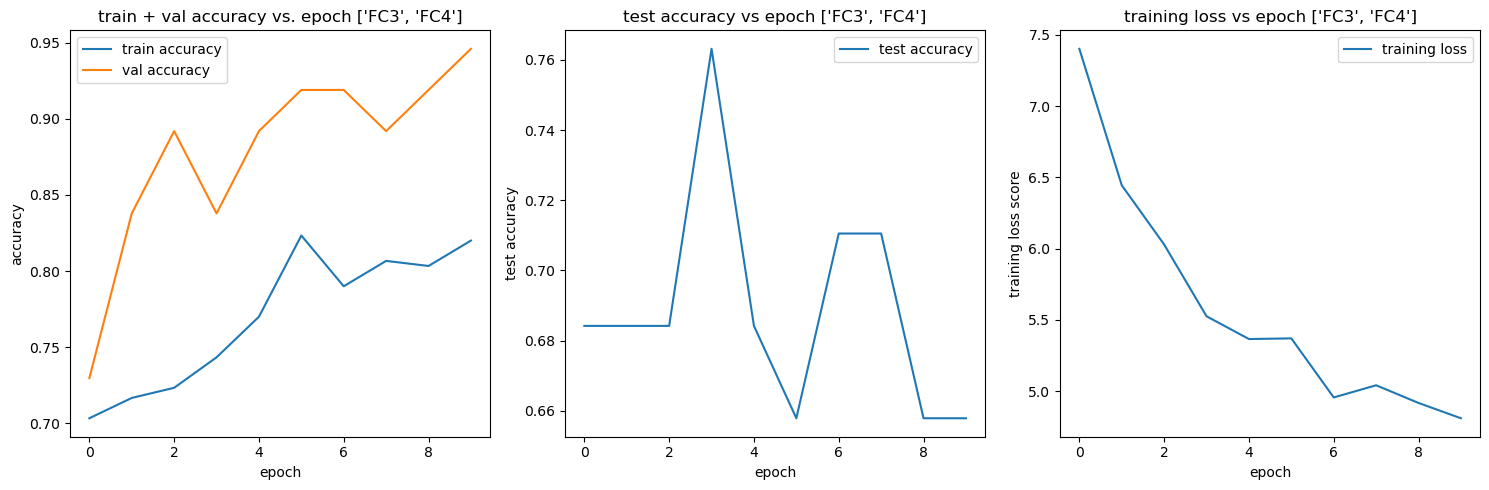

conf matrix:
[[13 11]
 [ 2 12]]


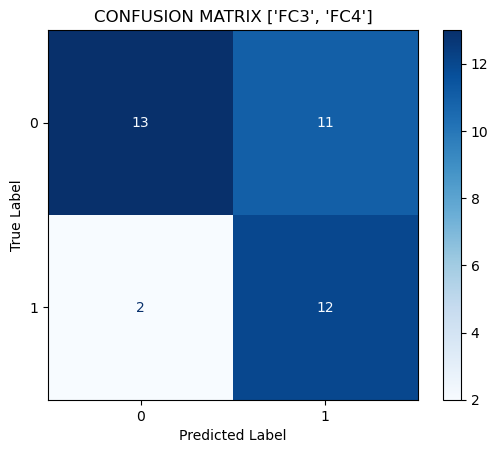

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
(375, 2, 300)
(375, 1, 300, 2)
(375,)

Epoch  0
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
['acc', 'auc', 'fmeasure']
Training Loss  10.745311319828033
Train -  [0.49333333333333335, 0.485650723025584, 0.5064935064935066]
Validation -  [0.5135135135135135, 0.4444444444444445, 0.5714285714285715]
Test -  [0.42105263157894735, 0.4077380952380952, 0.31250000000000006]

Epoch  1
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size([25, 1])
outputs.shape: torch.Size

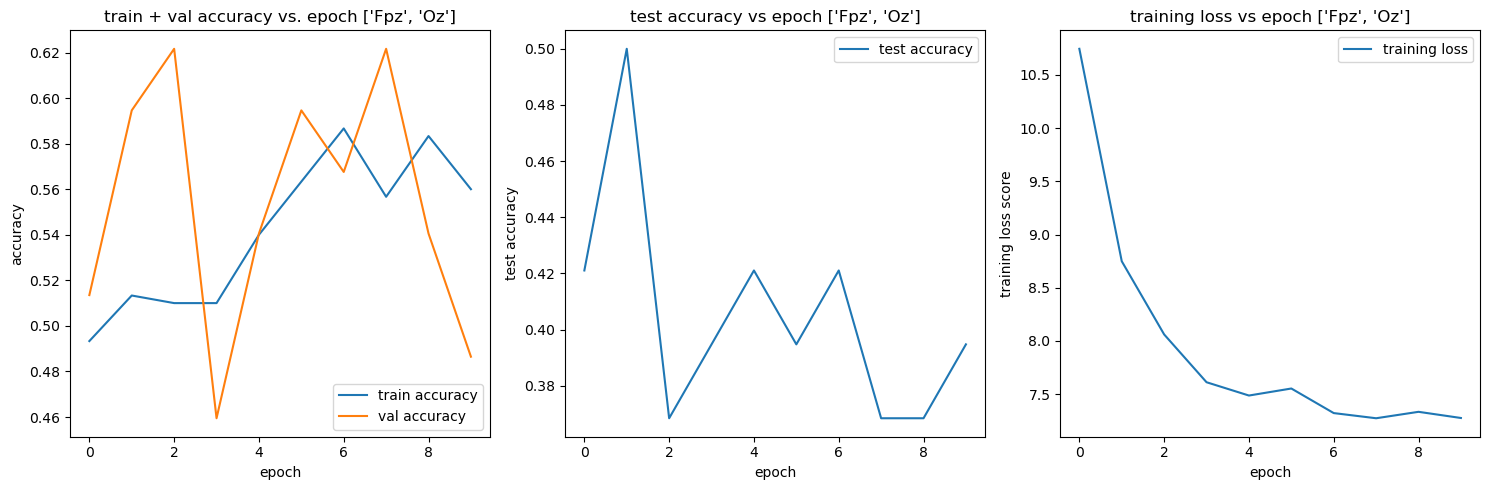

conf matrix:
[[ 9 15]
 [ 3 11]]


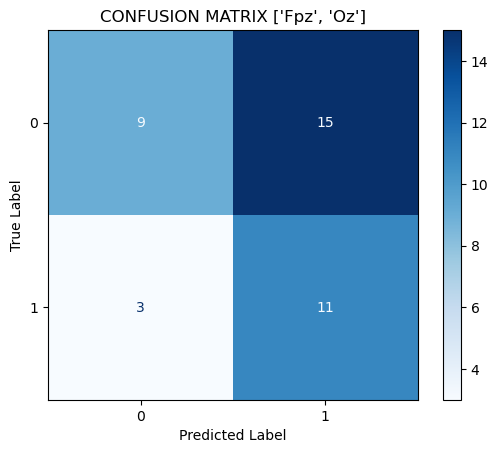

In [45]:
# define model - instantiate with every loop? or train the same model?
model = EEGNet(2, 300)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

batch_size = 25
num_train_epochs = 10

posch = ['FC3', 'FC4']
negch = ['Fpz', 'Oz']


# pos ctrl
epochsp = epochs_tot.copy().pick_channels(posch)
X_train, y_train, X_val, y_val, X_test, y_test = split_epochs(epochsp, 0.8)

run_net(model, batch_size, num_train_epochs, optimizer, criterion, X_train, y_train, X_val, y_val, X_test, y_test, f'{posch}', plot = True)

get_confusion_matrix(model, X_test, y_test, posch)

# pos ctrl
epochsn = epochs_tot.copy().pick_channels(negch)
X_train, y_train, X_val, y_val, X_test, y_test = split_epochs(epochsn, 0.8)

run_net(model, batch_size, num_train_epochs, optimizer, criterion, X_train, y_train, X_val, y_val, X_test, y_test, f'{negch}', plot = True)

get_confusion_matrix(model, X_test, y_test, negch)


    